In [46]:
import mici
import arviz
import numpy as np
import time
import matplotlib.pyplot as plt

seed = int( 10**6 * (time.time() % 1) )
rng = np.random.RandomState(seed)

# HMC vs NUTS vs MALA on a 100-dimensional isotropic Gaussian

In [7]:
n_dims = 100
n_samples = 10_000
n_chains = 10
n_warm_up_samples = 1_000

def neg_log_gauss_target(x):
    return np.sum(x**2)/2

def grad_neg_log_gauss_target(x):
    '''simple enough to write down'''
    return x

## Run NUTS chain

In [8]:
# NUTS

system = mici.systems.EuclideanMetricSystem(
    neg_log_dens= neg_log_gauss_target,
    grad_neg_log_dens= grad_neg_log_gauss_target
)

integrator = mici.integrators.LeapfrogIntegrator(system=system) 
sampler = mici.samplers.DynamicMultinomialHMC(system,integrator,rng,max_tree_depth=10)

adapters = [mici.adapters.DualAveragingStepSizeAdapter()]

final_states, traces, stats = sampler.sample_chains_with_adaptive_warm_up(
    n_warm_up_iter=n_warm_up_samples, 
    n_main_iter=n_samples, 
    init_states=[mici.states.ChainState(pos=np.zeros(n_dims),mom=None,dir=1)]*n_chains,
    adapters=adapters,
    monitor_stats=['accept_stat', 'diverging', 'n_step'],
    display_progress=True,
    n_process=n_chains)

Sampling stage: Adaptive warm up [00:15] > Main non-adaptive [02:30]

Chain 1/10: 100%|██████████|10000/10000 [02:28<00:00, 67.49it/s, accept_stat=0.810, diverging=0.00, n_step=7.00]

Chain 2/10: 100%|██████████|10000/10000 [02:29<00:00, 66.67it/s, accept_stat=0.815, diverging=0.00, n_step=7.00]

Chain 3/10: 100%|██████████|10000/10000 [02:30<00:00, 66.58it/s, accept_stat=0.813, diverging=0.00, n_step=7.00]

Chain 4/10: 100%|██████████|10000/10000 [02:30<00:00, 66.54it/s, accept_stat=0.814, diverging=0.00, n_step=7.00]

Chain 5/10: 100%|██████████|10000/10000 [02:29<00:00, 67.10it/s, accept_stat=0.814, diverging=0.00, n_step=7.00]

Chain 6/10: 100%|██████████|10000/10000 [02:30<00:00, 66.50it/s, accept_stat=0.814, diverging=0.00, n_step=7.00]

Chain 7/10: 100%|██████████|10000/10000 [02:28<00:00, 67.27it/s, accept_stat=0.817, diverging=0.00, n_step=7.00]

Chain 8/10: 100%|██████████|10000/10000 [02:29<00:00, 66.75it/s, accept_stat=0.814, diverging=0.00, n_step=7.00]

Chain 9/10: 100%|██████████|10000/10000 [02:28<00:00, 67.53it/s, accept_stat=0.813, diverging=0.00, n_step=7.00]

Chain 10/10: 100%|██████████|10000/10000 [02:30<00:00, 66.62it/s, accept_stat=0.813, diverging=0.00, n_step=7.00]

## Use same adapted step size for all samplers 

In [9]:
step_size = integrator.step_size
print(step_size)

0.5180178882359865


## Run HMC

In [16]:
print(f'Each NUTS sample takes {np.array(stats["n_step"]).mean()} gradient computations')

Each NUTS sample takes 7.0 gradient computations


In [19]:
hmc_n_steps = int(np.array(stats["n_step"]).mean()/2)
print(f'We set HMC to take {hmc_n_steps} leapfrog steps per sample.')

We set HMC to take 3 leapfrog steps per sample.


In [22]:
# HMC
hmc_integrator = mici.integrators.LeapfrogIntegrator(system=system, step_size=step_size) 
hmc_sampler = mici.samplers.StaticMetropolisHMC(system, hmc_integrator,rng, n_step=hmc_n_steps)

final_states_hmc, traces_hmc, stats_hmc = hmc_sampler.sample_chains(
    n_iter=n_samples, 
    init_states=[mici.states.ChainState(pos=np.zeros(n_dims),mom=None,dir=1)]*n_chains,
    monitor_stats=['accept_stat', 'diverging', 'n_step'],
    display_progress=True,
    n_process=n_chains)

Chain 1/10: 100%|██████████|10000/10000 [02:30<00:00, 66.40it/s, accept_stat=0.722, diverging=0.00, n_step=3.00]

Chain 2/10: 100%|██████████|10000/10000 [02:31<00:00, 65.94it/s, accept_stat=0.734, diverging=0.00, n_step=3.00]

Chain 3/10: 100%|██████████|10000/10000 [02:31<00:00, 66.09it/s, accept_stat=0.730, diverging=0.00, n_step=3.00]

Chain 4/10: 100%|██████████|10000/10000 [02:32<00:00, 65.64it/s, accept_stat=0.731, diverging=0.00, n_step=3.00]

Chain 5/10: 100%|██████████|10000/10000 [02:30<00:00, 66.36it/s, accept_stat=0.721, diverging=0.00, n_step=3.00]

Chain 6/10: 100%|██████████|10000/10000 [02:31<00:00, 66.05it/s, accept_stat=0.726, diverging=0.00, n_step=3.00]

Chain 7/10: 100%|██████████|10000/10000 [02:30<00:00, 66.40it/s, accept_stat=0.726, diverging=0.00, n_step=3.00]

Chain 8/10: 100%|██████████|10000/10000 [02:30<00:00, 66.51it/s, accept_stat=0.722, diverging=0.00, n_step=3.00]

Chain 9/10: 100%|██████████|10000/10000 [02:30<00:00, 66.54it/s, accept_stat=0.726, diverging=0.00, n_step=3.00]

Chain 10/10: 100%|██████████|10000/10000 [02:32<00:00, 65.67it/s, accept_stat=0.734, diverging=0.00, n_step=3.00]

## Run MALA

In [23]:
# MALA

mala_integrator = mici.integrators.LeapfrogIntegrator(system=system, step_size=step_size) 
mala_sampler = mici.samplers.StaticMetropolisHMC(system, mala_integrator,rng, n_step=1)

final_states_mala, traces_mala, stats_mala = mala_sampler.sample_chains(
    n_iter=n_samples, 
    init_states=[mici.states.ChainState(pos=np.zeros(n_dims),mom=None,dir=1)]*n_chains,
    monitor_stats=['accept_stat', 'diverging', 'n_step'],
    display_progress=True,
    n_process=n_chains)

Chain 1/10: 100%|██████████|10000/10000 [02:23<00:00, 69.61it/s, accept_stat=0.865, diverging=0.00, n_step=1.00]

Chain 2/10: 100%|██████████|10000/10000 [02:23<00:00, 69.54it/s, accept_stat=0.863, diverging=0.00, n_step=1.00]

Chain 3/10: 100%|██████████|10000/10000 [02:23<00:00, 69.67it/s, accept_stat=0.863, diverging=0.00, n_step=1.00]

Chain 4/10: 100%|██████████|10000/10000 [02:22<00:00, 70.10it/s, accept_stat=0.863, diverging=0.00, n_step=1.00]

Chain 5/10: 100%|██████████|10000/10000 [02:23<00:00, 69.54it/s, accept_stat=0.863, diverging=0.00, n_step=1.00]

Chain 6/10: 100%|██████████|10000/10000 [02:22<00:00, 70.06it/s, accept_stat=0.865, diverging=0.00, n_step=1.00]

Chain 7/10: 100%|██████████|10000/10000 [02:22<00:00, 69.98it/s, accept_stat=0.861, diverging=0.00, n_step=1.00]

Chain 8/10: 100%|██████████|10000/10000 [02:22<00:00, 70.23it/s, accept_stat=0.865, diverging=0.00, n_step=1.00]

Chain 9/10: 100%|██████████|10000/10000 [02:21<00:00, 70.68it/s, accept_stat=0.862, diverging=0.00, n_step=1.00]

Chain 10/10: 100%|██████████|10000/10000 [02:21<00:00, 70.53it/s, accept_stat=0.863, diverging=0.00, n_step=1.00]

## Total gradient call

Each method takes (`n_step` x `n_chains` x `n_samples`) gradient calls. `n_step` is 7 for NUTS, 3 for HMC, and 1 for MALA.

In [147]:
n_burn_samples=5000 # discard burn in samples

In [148]:
n_grad_calls_nuts = (n_samples-n_burn_samples) * n_chains * np.array(stats["n_step"]).mean()
n_grad_calls_hmc = (n_samples-n_burn_samples) * n_chains * hmc_n_steps
n_grad_calls_mala = (n_samples-n_burn_samples) * n_chains

In [149]:
print(f'Gradient calls for NUTS = {n_grad_calls_nuts} / HMC = {n_grad_calls_hmc} / MALA: {n_grad_calls_mala}')

Gradient calls for NUTS = 350000.0 / HMC = 150000 / MALA: 50000


We can look at the call counts in the states to double check.

In [150]:
# Inspect 'grad_neg_log_dens' to confirm
final_states[0]._call_counts # NUTS should be 70_000 (without burn in)

Counter({('EuclideanMetricSystem.neg_log_dens', 140204894906896): 8299,
         ('EuclideanMetricSystem.dh2_dmom', 140204894906896): 17595,
         ('EuclideanMetricSystem.h2', 140204894906896): 9298,
         ('EuclideanMetricSystem.grad_neg_log_dens', 140204894906896): 8302,
         ('EuclideanMetricSystem.neg_log_dens', 140204894964560): 70001,
         ('EuclideanMetricSystem.dh2_dmom', 140204894964560): 150001,
         ('EuclideanMetricSystem.h2', 140204894964560): 80001,
         ('EuclideanMetricSystem.grad_neg_log_dens', 140204894964560): 70002})

In [151]:
final_states_hmc[0]._call_counts #HMC should be 30_000 (without burn in)

Counter({('EuclideanMetricSystem.neg_log_dens', 140204894964944): 10001,
         ('EuclideanMetricSystem.dh2_dmom', 140204894964944): 50001,
         ('EuclideanMetricSystem.h2', 140204894964944): 20001,
         ('EuclideanMetricSystem.grad_neg_log_dens', 140204894964944): 30136})

In [152]:
final_states_mala[0]._call_counts # MALA should be 10_000 (without burn in)

Counter({('EuclideanMetricSystem.neg_log_dens', 140211045125456): 10001,
         ('EuclideanMetricSystem.dh2_dmom', 140211045125456): 30001,
         ('EuclideanMetricSystem.h2', 140211045125456): 20001,
         ('EuclideanMetricSystem.grad_neg_log_dens', 140211045125456): 10003})

## Compute ESS of position for each dimension

In [153]:
pos_nuts = np.array(traces['pos'])[:,n_burn_samples:,:]
pos_hmc = np.array(traces_hmc['pos'])[:,n_burn_samples:,:]
pos_mala = np.array(traces_mala['pos'])[:,n_burn_samples:,:]

ess_pos_nuts = arviz.ess(arviz.convert_to_dataset(pos_nuts)).x
ess_pos_hmc = arviz.ess(arviz.convert_to_dataset(pos_hmc)).x
ess_pos_mala = arviz.ess(arviz.convert_to_dataset(pos_mala)).x

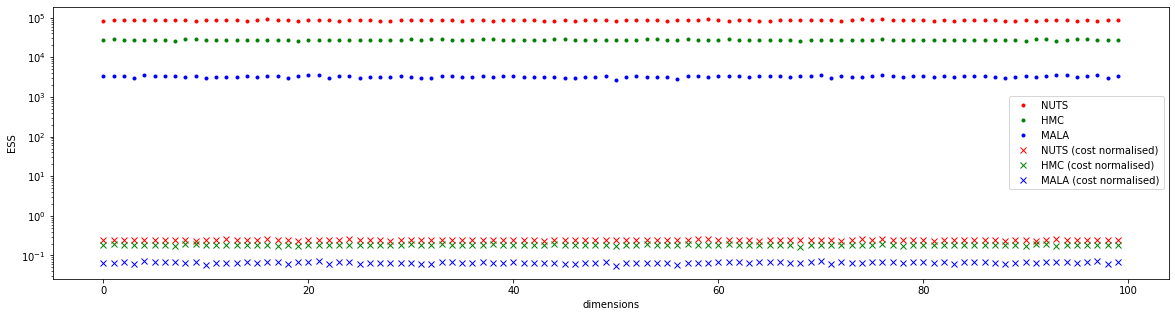

In [154]:
plt.figure(figsize=(20,5))
plt.plot(ess_pos_nuts, 'r.', label='NUTS')
plt.plot(ess_pos_hmc, 'g.', label='HMC') 
plt.plot(ess_pos_mala, 'b.', label='MALA')
plt.plot(ess_pos_nuts/n_grad_calls_nuts, 'rx', label='NUTS (cost normalised)')
plt.plot(ess_pos_hmc/n_grad_calls_hmc, 'gx',label='HMC (cost normalised)') 
plt.plot(ess_pos_mala/n_grad_calls_mala, 'bx',label='MALA (cost normalised)')
plt.yscale('log')
plt.xlabel('dimensions')
plt.ylabel('ESS')
plt.legend();

## Compute ESS of squared position for each dimension

In [155]:
ess_pos_sq_nuts = arviz.ess(arviz.convert_to_dataset(pos_nuts**2)).x
ess_pos_sq_hmc = arviz.ess(arviz.convert_to_dataset(pos_hmc**2)).x
ess_pos_sq_mala = arviz.ess(arviz.convert_to_dataset(pos_mala**2)).x

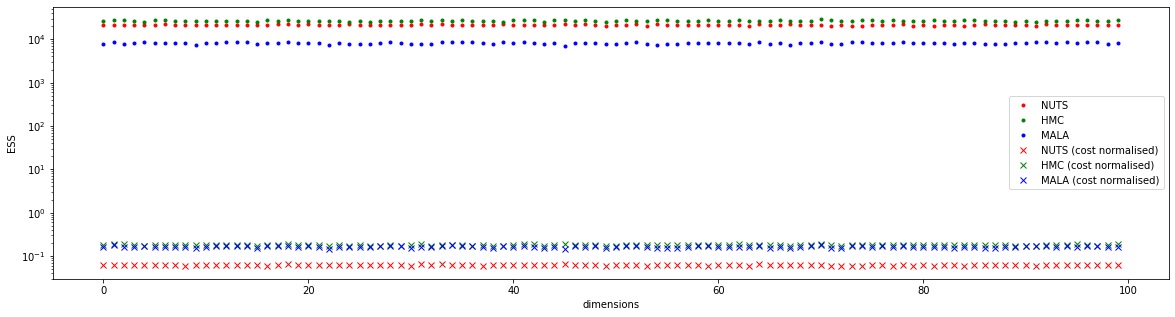

In [156]:
plt.figure(figsize=(20,5))
plt.plot(ess_pos_sq_nuts, 'r.', label='NUTS')
plt.plot(ess_pos_sq_hmc, 'g.', label='HMC') 
plt.plot(ess_pos_sq_mala, 'b.', label='MALA')
plt.plot(ess_pos_sq_nuts/n_grad_calls_nuts, 'rx', label='NUTS (cost normalised)')
plt.plot(ess_pos_sq_hmc/n_grad_calls_hmc, 'gx',label='HMC (cost normalised)') 
plt.plot(ess_pos_sq_mala/n_grad_calls_mala, 'bx',label='MALA (cost normalised)')
plt.yscale('log')
plt.xlabel('dimensions')
plt.ylabel('ESS')
plt.legend();

## Compute ESS of negative log target

In [157]:
neg_log_target_nuts = np.array([[neg_log_gauss_target(p) for p in p_chain] for p_chain in pos_nuts])
neg_log_target_hmc = np.array([[neg_log_gauss_target(p) for p in p_chain] for p_chain in pos_hmc])
neg_log_target_mala = np.array([[neg_log_gauss_target(p) for p in p_chain] for p_chain in pos_mala])

In [158]:
ess_neg_log_target_nuts = arviz.ess(neg_log_target_nuts)
ess_neg_log_target_hmc = arviz.ess(neg_log_target_hmc)
ess_neg_log_target_mala = arviz.ess(neg_log_target_mala)

In [159]:
print(f'Neg log target ESS for NUTS = {ess_neg_log_target_nuts:.2f} \
/ HMC = {ess_neg_log_target_hmc:.2f} \
/ MALA: {ess_neg_log_target_mala:.2f}')

Neg log target ESS for NUTS = 16510.14 / HMC = 17579.99 / MALA: 5609.63


In [160]:
print(f'Normalized neg log target ESS for NUTS = {ess_neg_log_target_nuts/n_grad_calls_nuts:.2f} \
/ HMC = {ess_neg_log_target_hmc/n_grad_calls_hmc:.2f} \
/ MALA: {ess_neg_log_target_mala/n_grad_calls_mala:.2f}')

Normalized neg log target ESS for NUTS = 0.05 / HMC = 0.12 / MALA: 0.11


## Visualise position (1st dimension) samples

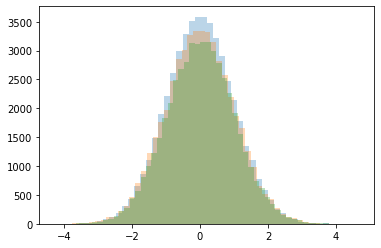

In [161]:
plt.hist(pos_nuts[:,:,0].flatten(),bins=50,alpha=0.3);
plt.hist(pos_hmc[:,:,0].flatten(),bins=50,alpha=0.3);
plt.hist(pos_mala[:,:,0].flatten(),bins=50,alpha=0.3);

## Visualise position squared (1st dimension) samples

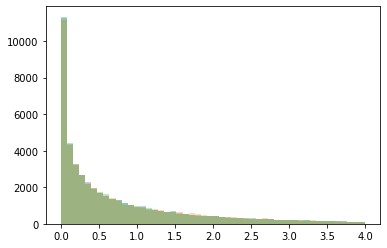

In [162]:
plt.hist((pos_nuts[:,:,0]**2).flatten(),bins=50,alpha=0.3, range=(0,4));
plt.hist((pos_hmc[:,:,0]**2).flatten(),bins=50,alpha=0.3, range=(0,4));
plt.hist((pos_mala[:,:,0]**2).flatten(),bins=50,alpha=0.3, range=(0,4));

## Visualise neg log target samples

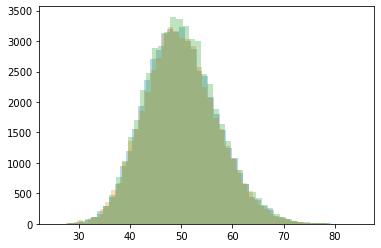

In [163]:
plt.hist(neg_log_target_nuts.flatten(),bins=50,alpha=0.3);
plt.hist(neg_log_target_hmc.flatten(),bins=50,alpha=0.3);
plt.hist(neg_log_target_mala.flatten(),bins=50,alpha=0.3);